In [ ]:
import pandas as pd

# Read and preparing Data

In [ ]:
data_series = pd.read_csv("../data/interim/bicimad_time_series.csv", sep=',')

In [ ]:
data_series['unlock_date'] = pd.to_datetime(data_series['unlock_date'], format='%Y-%m-%d')

In [ ]:
data_series = data_series.set_index(data_series['unlock_date'])

# Time Series

Evaluareamos y predecidermos según cada dato de nuestro data_series, teniendo como índice la fecha de desbloqueo 'unlock_date'

# LSTM

In [ ]:
import numpy as np 
np.random.seed(42)
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout, Bidirectional
from keras.callbacks import EarlyStopping
from statsmodels.tools.eval_measures import rmse 
from sklearn.metrics import mean_absolute_error 
from sklearn.metrics import r2_score 
from keras.models import load_model
import warnings; 
warnings.simplefilter('ignore') 
from pickle import dump

* Trip_minutes

In [ ]:
data_series_LSTM = data_series.drop(columns=['idDriver', 'idBike',  'fleet', 
       'unlock_hour', 'latitude_unlock', 'longitude_unlock', 'station_unlock',
       'dock_unlock',  'lock_date', 'lock_hour',
       'latitude_lock', 'longitude_lock', 'station_lock', 'dock_lock', 'trip_day_of_week',
       'trip_duration_category', 'station_unlock_count', 'station_lock_count',
       'travel_direction', 'idDriver_n', 'unlock_station_name_n',
       'lock_station_name_n', 'lock_station_name', 'unlock_station_name'])

In [ ]:
data_series_LSTM = data_series_LSTM.set_index(data_series_LSTM['unlock_date'])

In [ ]:
data_series_LSTM.info()

In [ ]:
#Dividimos en train y test manualmente al ser una serie temporal
X_train = data_series_LSTM[data_series_LSTM['unlock_date'] < '2022-10-01'].drop(columns=['unlock_date'])
y_train = data_series_LSTM[data_series_LSTM['unlock_date'] < '2022-10-01']['trip_minutes']
X_test = data_series_LSTM[data_series_LSTM['unlock_date'] >= '2022-10-01'].drop(columns=['unlock_date'])
y_test = data_series_LSTM[data_series_LSTM['unlock_date'] >= '2022-10-01']['trip_minutes']

In [ ]:
# Crear el modelo
model_LSTM = Sequential()

# Agregar capas al modelo
model_LSTM.add(Bidirectional(LSTM(50, return_sequences=True), input_shape=(None, 6)))
model_LSTM.add(Dropout(0.2))
model_LSTM.add(LSTM(50, return_sequences=False))
model_LSTM.add(Dropout(0.2))
model_LSTM.add(Dense(25))
model_LSTM.add(Dense(1))

In [ ]:
# Crear la instancia de EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', patience=2)
# Compilar el modelo
model_LSTM.compile(optimizer='adam', loss='mean_squared_error')
# Entrenar el modelo
model_LSTM.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.2, callbacks=[early_stopping])

In [ ]:
# Evaluar el modelo
train_loss = model_LSTM.evaluate(X_train, y_train, verbose=0)
test_loss = model_LSTM.evaluate(X_test, y_test, verbose=0)

print(f'Train Loss: {train_loss}, Test Loss: {test_loss}')

In [ ]:
# Almacenar la historia del entrenamiento
history = model_LSTM.fit(X_train, y_train, epochs=100, batch_size=32, validation_split=0.2, callbacks=[early_stopping])

# Graficar la pérdida de entrenamiento y validación
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

In [ ]:
# Guardar el modelo
model_LSTM.save('model_LSTM.h5')

# Cargar el modelo
LSTM_model = keras.models.load_model('model_LSTM.h5')

# ARIMA

In [17]:
import numpy as np
np.random.seed(42) 
import pandas as pd 
from statsmodels.tsa.statespace.sarimax import SARIMAX 
from pmdarima import auto_arima                         
from statsmodels.tools.eval_measures import rmse 
import matplotlib.pyplot as plt 
from sklearn.metrics import mean_absolute_error 
from sklearn.metrics import r2_score 
import warnings   
warnings.filterwarnings("ignore") 

* Trip_minutes

In [15]:
data_series_minutes = data_series['trip_minutes'] 
data_series_minutes = data_series_minutes.to_frame() 
data_series_minutes.rename(columns={'trip_minutes':'Real'},inplace = True)   
data_minutes_mean = data_series_minutes.groupby(data_series_minutes.index).mean()
values = data_minutes_mean.values 

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.43764D+00    |proj g|=  1.52520D-01

At iterate    5    f=  2.40539D+00    |proj g|=  2.17458D-02

At iterate   10    f=  2.38765D+00    |proj g|=  7.37545D-03

At iterate   15    f=  2.38447D+00    |proj g|=  2.51765D-03


 This problem is unconstrained.



At iterate   20    f=  2.38431D+00    |proj g|=  2.40912D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     23     25      1     0     0   2.827D-05   2.384D+00
  F =   2.3843107450402674     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


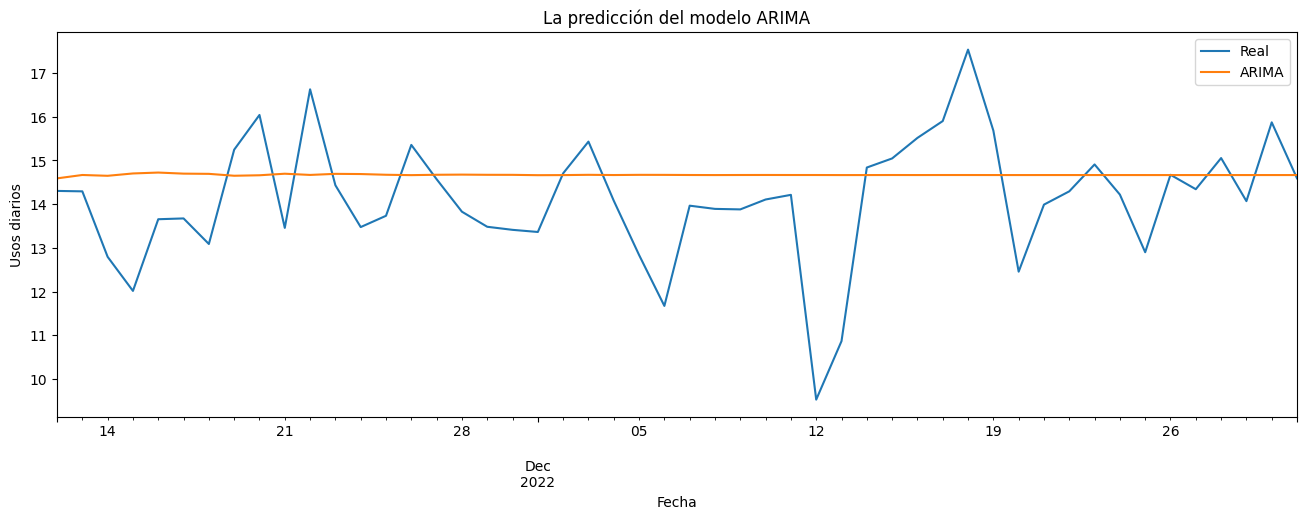

In [18]:
auto_arima(values, seasonal=True, m=12).summary()  
train_data_min = data_minutes_mean[:len(data_minutes_mean)-50] 
test_data_min = data_minutes_mean[len(data_minutes_mean)-50:] 

arima_model = SARIMAX(train_data_min['Real'], order = (1,1,1), seasonal_order = (1,0,1,12))  

arima_result = arima_model.fit() 
arima_result.summary()  
arima_pred = arima_result.predict(start = len(train_data_min), end = len(data_minutes_mean)-1, typ="levels").rename("ARIMA")
#arima_pred = arima_pred.to_frame()   
test_data_min = pd.concat([test_data_min, arima_pred],axis=1)   
test_data_min['Real'].plot(figsize = (16,5), legend=True) 
arima_pred.plot(legend = True);   
plt.title('La predicción del modelo ARIMA') 
plt.xlabel('Fecha') 
plt.ylabel('Usos diarios') 
plt.show()

In [19]:
rmse_arima = round(rmse(test_data_min['Real'], test_data_min['ARIMA']),2) 
mse_arima = round((rmse_arima**2),2) 
mae_arima = round(mean_absolute_error(test_data_min['Real'], test_data_min['ARIMA']),2)  

r2_arima = round(r2_score(test_data_min['Real'], test_data_min['ARIMA']),3) 

In [20]:
def mean_absolute_percentage_error(y_true, y_pred):      
    y_true, y_pred = np.array(y_true), np.array(y_pred)     
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100 
mape = round(mean_absolute_percentage_error(y_true=test_data_min['Real'],                    
            y_pred=test_data_min['ARIMA']),2) 
n_features = 1 
n = len(test_data_min['Real']) 
p = n_features 
adjusted_R2_arima = round(1-((1-r2_arima)*(n-1))/(n-p-1),3)

print(f'MSE: {mse_arima}\nRMSE: {rmse_arima}\nMAE: {mae_arima}\nMAPE: {mape}%\nR^2: {r2_arima}\nAdjusted R^2: {adjusted_R2_arima}') 

MSE: 2.22
RMSE: 1.49
MAE: 1.1
MAPE: 8.44%
R^2: -0.164
Adjusted R^2: -0.188


* Distance

In [26]:
data_series_distance = data_series['distance'] 
data_series_distance = data_series_distance.to_frame() 
data_series_distance.rename(columns={'distance':'Real'},inplace = True)   
data_distance_mean = data_series_distance.groupby(data_series_distance.index).mean()
values_dis = data_distance_mean.values 

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -3.35474D-02    |proj g|=  1.89405D-01

At iterate    5    f= -7.83201D-02    |proj g|=  9.17681D-02

At iterate   10    f= -1.17944D-01    |proj g|=  6.04750D-02


 This problem is unconstrained.



At iterate   15    f= -1.20974D-01    |proj g|=  2.73704D-02

At iterate   20    f= -1.21245D-01    |proj g|=  5.41086D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     23     34      1     0     0   3.178D-03  -1.212D-01
  F = -0.12124552880797999     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


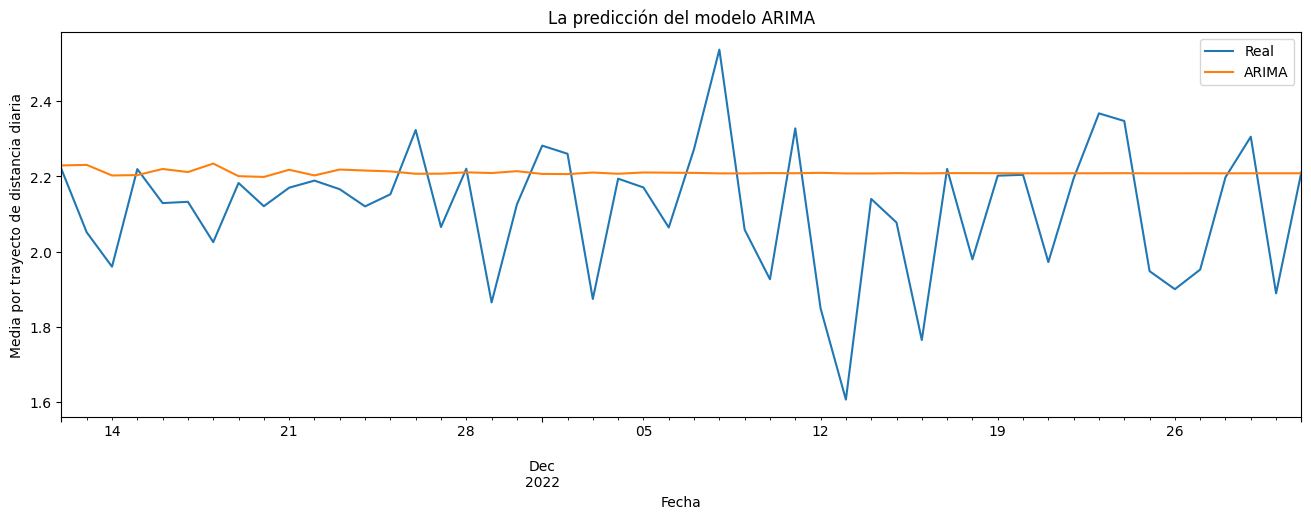

In [33]:
auto_arima(values_dis, seasonal=True, m=12).summary()  
train_data_dis = data_distance_mean[:len(data_distance_mean)-50] 
test_data_dis = data_distance_mean[len(data_distance_mean)-50:] 

arima_model = SARIMAX(train_data_dis['Real'], order = (1,1,1), seasonal_order = (1,0,1,12))  

arima_result = arima_model.fit() 
arima_result.summary()  
arima_pred = arima_result.predict(start = len(train_data_dis), end = len(data_distance_mean)-1, typ="levels").rename("ARIMA")
#arima_pred = arima_pred.to_frame()   
test_data_dis = pd.concat([test_data_dis, arima_pred],axis=1)   
test_data_dis['Real'].plot(figsize = (16,5), legend=True) 
arima_pred.plot(legend = True);   
plt.title('La predicción del modelo ARIMA') 
plt.xlabel('Fecha') 
plt.ylabel('Media por trayecto de distancia diaria') 
plt.show()

In [30]:
rmse_arima = round(rmse(test_data_dis['Real'], test_data_dis['ARIMA']),2) 
mse_arima = round((rmse_arima**2),2) 
mae_arima = round(mean_absolute_error(test_data_dis['Real'], test_data_dis['ARIMA']),2)  

r2_arima = round(r2_score(test_data_dis['Real'], test_data_dis['ARIMA']),3) 

In [31]:
def mean_absolute_percentage_error(y_true, y_pred):      
    y_true, y_pred = np.array(y_true), np.array(y_pred)     
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100 
mape = round(mean_absolute_percentage_error(y_true=test_data_dis['Real'],                    
            y_pred=test_data_dis['ARIMA']),2) 
n_features = 1 
n = len(test_data_dis['Real']) 
p = n_features 
adjusted_R2_arima = round(1-((1-r2_arima)*(n-1))/(n-p-1),3)

print(f'MSE: {mse_arima}\nRMSE: {rmse_arima}\nMAE: {mae_arima}\nMAPE: {mape}%\nR^2: {r2_arima}\nAdjusted R^2: {adjusted_R2_arima}') 

MSE: 0.04
RMSE: 0.2
MAE: 0.14
MAPE: 7.24%
R^2: -0.318
Adjusted R^2: -0.345


* idBikes

* idDrivers